In [47]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [57]:
# Dataset_dir = 'ohlc_data'
root_path = Path(os.getcwd())
dataset_file_name = 'Signal_EURUSD.csv'
data = pd.read_csv(os.path.join(root_path, dataset_file_name), index_col=0)

In [58]:
data

,Open,High,Low,Close,Volume,Time,Date,Percentage_Change,Signal
1,1.20481,1.20569,1.20479,1.20538,1254,2015-01-02 08:00:00,2015-01-02 08:00:00,-0.380995,Sell
2,1.20537,1.20574,1.20341,1.20553,3394,2015-01-02 09:00:00,2015-01-02 09:00:00,0.012444,Hold
3,1.20556,1.20689,1.20442,1.20469,4590,2015-01-02 10:00:00,2015-01-02 10:00:00,-0.069679,Hold
4,1.20468,1.20599,1.20380,1.20573,4335,2015-01-02 11:00:00,2015-01-02 11:00:00,0.086329,Sell
5,1.20573,1.20573,1.20415,1.20501,2731,2015-01-02 12:00:00,2015-01-02 12:00:00,-0.059715,Hold
...,...,...,...,...,...,...,...,...,...
61933,1.03816,1.03974,1.03770,1.03913,5104,2024-12-20 10:00:00,2024-12-20 10:00:00,0.092470,Hold
61934,1.03913,1.03915,1.03749,1.03817,4389,2024-12-20 11:00:00,2024-12-20 11:00:00,-0.092385,Hold
61935,1.03818,1.03921,1.03803,1.03908,3521,2024-12-20 12:00:00,2024-12-20 12:00:00,0.087654,Hold
61936,1.03908,1.03964,1.03785,1.03906,3663,2024-12-20 13:00:00,2024-12-20 13:00:00,-0.001925,Hold


In [59]:
data['Signal'] = data['Signal'].map({'Buy': 1, 'Sell': -1, 'Hold': 0})

In [60]:
data['Signal'].value_counts()

 0    61122
 1      411
-1      404
Name: Signal, dtype: int64

In [61]:
features_df = feature_generate(data)

In [62]:
features_df_nonan = features_df.dropna().reset_index().drop(columns=['index'])


In [63]:
features_df_nonan

,Open,High,Low,Close,Volume,Time,Date,Percentage_Change,Signal,SMA_5,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,1.17568,1.18456,1.17545,1.18246,9362,2015-01-14 15:00:00,2015-01-14 15:00:00,0.576688,1,1.176728,...,1.177528,1.181121,1.173936,0.439144,-69502,63.47436,-1.365421e+01,39.145134,3.972868,4203.689267
1,1.18246,1.18391,1.17874,1.17898,8874,2015-01-14 16:00:00,2015-01-14 16:00:00,-0.294302,0,1.177648,...,1.177647,1.181268,1.174026,0.096787,-78376,-30.88152,-8.063763e+03,36.877171,-1.230980,2080.286164
2,1.17899,1.17964,1.17708,1.17855,7477,2015-01-14 17:00:00,2015-01-14 17:00:00,-0.036472,0,1.178202,...,1.177757,1.181346,1.174168,0.106175,-85853,-3.21511,-6.953895e+03,38.423683,-0.510312,1375.643894
3,1.17856,1.18103,1.17856,1.18056,5668,2015-01-14 18:00:00,2015-01-14 18:00:00,0.170549,0,1.179246,...,1.177932,1.181714,1.174150,0.174798,-80185,11.39268,-3.442948e+03,36.549635,0.945065,2079.442229
4,1.18054,1.18131,1.17839,1.17868,3960,2015-01-14 19:00:00,2015-01-14 19:00:00,-0.159246,0,1.179846,...,1.178006,1.181786,1.174227,-0.035620,-84145,-7.44480,-6.616373e+03,33.361254,-0.714538,1168.593499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61732,1.03737,1.03842,1.03715,1.03817,5316,2024-12-20 09:00:00,2024-12-20 09:00:00,0.076153,0,1.036788,...,1.036971,1.039556,1.034387,0.206558,-409214,4.19964,-2.730022e+06,51.680099,1.219467,2495.716694
61733,1.03816,1.03974,1.03770,1.03913,5104,2024-12-20 10:00:00,2024-12-20 10:00:00,0.092470,0,1.037396,...,1.036965,1.039526,1.034404,0.233431,-404110,4.89984,-2.727970e+06,51.749177,1.426006,3590.743366
61734,1.03913,1.03915,1.03749,1.03817,4389,2024-12-20 11:00:00,2024-12-20 11:00:00,-0.092385,0,1.037874,...,1.036884,1.039158,1.034611,0.239454,-408499,-4.21344,-2.728763e+06,60.113819,-1.033600,3459.898090
61735,1.03818,1.03921,1.03803,1.03908,3521,2024-12-20 12:00:00,2024-12-20 12:00:00,0.087654,0,1.038386,...,1.036865,1.039050,1.034680,0.253751,-404978,3.20411,-2.726018e+06,65.101381,0.959608,3965.302700


In [32]:
features_df_nonan.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time', 'Date',
       'Percentage_Change', 'Signal', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10',
       'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100', 'EMA_100', 'SMA_200',
       'EMA_200', 'RSI_14', 'Stochastic_K', 'Stochastic_D', 'Williams_%R',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX',
       'CCI', 'Bollinger_Mid', 'Bollinger_Upper', 'Bollinger_Lower', 'ROC',
       'OBV', 'Force_Index', 'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator'],
      dtype='object')

In [34]:
# Usage with topk='all' to select all available features after initial reduction
# selected_ftr, f_idx = features_selection(features_df_nonan, selection_method='all', topk='all', num_features=16)

In [37]:
features_df_nonan

,Open,High,Low,Close,Volume,Time,Date,Percentage_Change,Signal,SMA_5,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,1.17568,1.18456,1.17545,1.18246,9362,2015-01-14 15:00:00,2015-01-14 15:00:00,0.576688,1,1.176728,...,1.177528,1.181121,1.173936,0.439144,-69502,63.47436,-1.365421e+01,39.145134,3.972868,4203.689267
1,1.18246,1.18391,1.17874,1.17898,8874,2015-01-14 16:00:00,2015-01-14 16:00:00,-0.294302,0,1.177648,...,1.177647,1.181268,1.174026,0.096787,-78376,-30.88152,-8.063763e+03,36.877171,-1.230980,2080.286164
2,1.17899,1.17964,1.17708,1.17855,7477,2015-01-14 17:00:00,2015-01-14 17:00:00,-0.036472,0,1.178202,...,1.177757,1.181346,1.174168,0.106175,-85853,-3.21511,-6.953895e+03,38.423683,-0.510312,1375.643894
3,1.17856,1.18103,1.17856,1.18056,5668,2015-01-14 18:00:00,2015-01-14 18:00:00,0.170549,0,1.179246,...,1.177932,1.181714,1.174150,0.174798,-80185,11.39268,-3.442948e+03,36.549635,0.945065,2079.442229
4,1.18054,1.18131,1.17839,1.17868,3960,2015-01-14 19:00:00,2015-01-14 19:00:00,-0.159246,0,1.179846,...,1.178006,1.181786,1.174227,-0.035620,-84145,-7.44480,-6.616373e+03,33.361254,-0.714538,1168.593499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61732,1.03737,1.03842,1.03715,1.03817,5316,2024-12-20 09:00:00,2024-12-20 09:00:00,0.076153,0,1.036788,...,1.036971,1.039556,1.034387,0.206558,-409214,4.19964,-2.730022e+06,51.680099,1.219467,2495.716694
61733,1.03816,1.03974,1.03770,1.03913,5104,2024-12-20 10:00:00,2024-12-20 10:00:00,0.092470,0,1.037396,...,1.036965,1.039526,1.034404,0.233431,-404110,4.89984,-2.727970e+06,51.749177,1.426006,3590.743366
61734,1.03913,1.03915,1.03749,1.03817,4389,2024-12-20 11:00:00,2024-12-20 11:00:00,-0.092385,0,1.037874,...,1.036884,1.039158,1.034611,0.239454,-408499,-4.21344,-2.728763e+06,60.113819,-1.033600,3459.898090
61735,1.03818,1.03921,1.03803,1.03908,3521,2024-12-20 12:00:00,2024-12-20 12:00:00,0.087654,0,1.038386,...,1.036865,1.039050,1.034680,0.253751,-404978,3.20411,-2.726018e+06,65.101381,0.959608,3965.302700


In [38]:
len(features_df_nonan.columns)

43

In [64]:
# Exclude the 'Signal' column and select only numeric data
X = features_df_nonan.drop(columns=['Signal', 'Percentage_Change']).select_dtypes(include=[np.number]).values
y = features_df_nonan['Signal'].values  # Target variable
# Splitting the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8, 
    test_size=0.2, 
    random_state=2, 
    shuffle=True, 
    stratify=y
        )

In [65]:
# Uncomment the following lines if you want to handle class imbalance
# 'not majority': resample all classes but the majority class
smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
x_train, y_train = smote.fit_resample(x_train, y_train)
print('Resampled dataset shape:', Counter(y_train))

Resampled dataset shape: Counter({0: 48741, 1: 48741, -1: 48741})


In [66]:
# Dynamic train-validation split
train_split = 0.9 if 0.8 * x_train.shape[0] < 2500 else 0.8
print('train_split =', train_split)

# Split the training set further into training and cross-validation sets
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, 
    train_size=train_split, 
    test_size=1-train_split, 
    random_state=2, 
    shuffle=True, 
    stratify=y_train
)

# Choose between MinMaxScaler or StandardScaler
scaler = MinMaxScaler(feature_range=(0, 1))  # For Min-Max scaling
# scaler = StandardScaler()                   # For Standard scaling

# Apply scaling to training, cross-validation, and test sets
x_train = scaler.fit_transform(x_train)
x_cv = scaler.transform(x_cv)
x_test = scaler.transform(x_test)

# Copying the main training set for further operations if needed
x_main = x_train.copy()

# Printing the shapes of train, cross-validation, and test sets
print("Shape of x, y train/cv/test:", 
      x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)


# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Reshape inputs for CNN
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # Add channel dimension
x_cv = x_cv.reshape((x_cv.shape[0], x_cv.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Normalize data if not already normalized
x_train = x_train / np.max(x_train)
x_cv = x_cv / np.max(x_cv)
x_test = x_test / np.max(x_test)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_cv_onehot = to_categorical(y_cv, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
])

## If One hot encoded
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])



train_split = 0.8
Shape of x, y train/cv/test: (116978, 39) (116978,) (29245, 39) (29245,) (12348, 39) (12348,)


In [67]:
### If one hot encoded
history = model.fit(x_train, y_train_onehot, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(x_cv, y_cv_onehot))

                    # if One hot the Evaluate the model like below
test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/10
3656/3656 [==============================] - 29s 8ms/step - loss: 0.3052 - accuracy: 0.8943 - val_loss: 1.3920 - val_accuracy: 0.6119
Epoch 2/10
3656/3656 [==============================] - 28s 8ms/step - loss: 0.1694 - accuracy: 0.9381 - val_loss: 2.1537 - val_accuracy: 0.6145
Epoch 3/10
3656/3656 [==============================] - 27s 7ms/step - loss: 0.1351 - accuracy: 0.9497 - val_loss: 2.8999 - val_accuracy: 0.6111
Epoch 4/10
3656/3656 [==============================] - 27s 7ms/step - loss: 0.1162 - accuracy: 0.9573 - val_loss: 3.5050 - val_accuracy: 0.6070
Epoch 5/10
3656/3656 [==============================] - 30s 8ms/step - loss: 0.1052 - accuracy: 0.9617 - val_loss: 3.1697 - val_accuracy: 0.5962
Epoch 6/10
3656/3656 [==============================] - 30s 8ms/step - loss: 0.0967 - accuracy: 0.9651 - val_loss: 4.4129 - val_accuracy: 0.5953
Epoch 7/10
3656/3656 [==============================] - 31s 8ms/step - loss: 0.0896 - accuracy: 0.9686 - val_loss: 5.3068 - val_ac

386/386 [==============================] - 1s 2ms/step
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[11580   328   278]
 [   13    67     2]
 [    9     2    69]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     12186
           1       0.17      0.82      0.28        82
           2       0.20      0.86      0.32        80

    accuracy                           0.95     12348
   macro avg       0.45      0.88      0.53     12348
weighted avg       0.99      0.95      0.96     12348



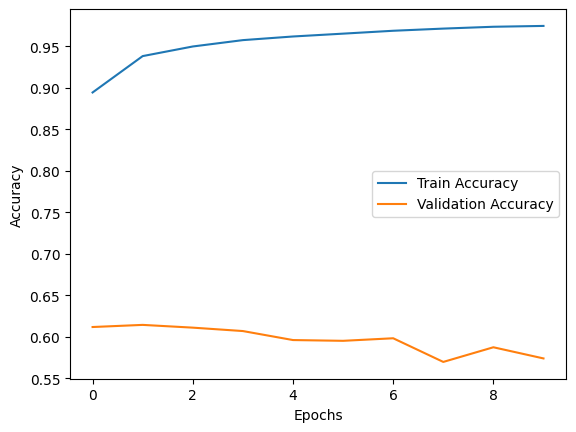

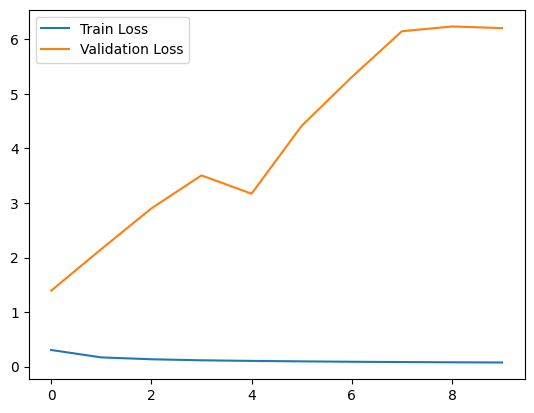

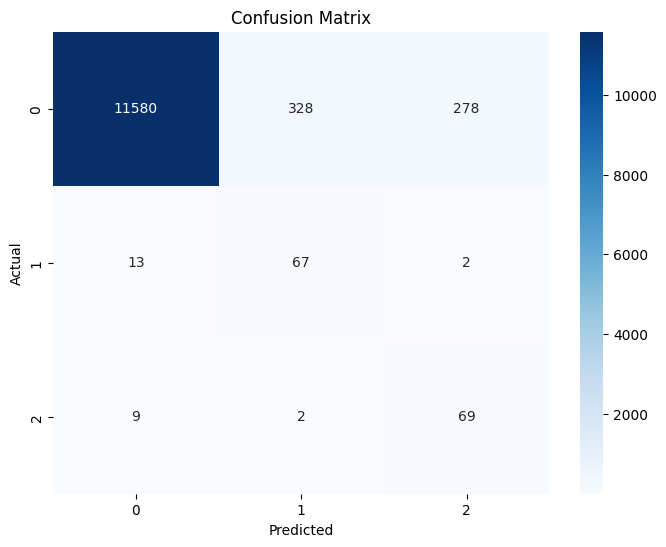

In [69]:
# Get predictions
y_pred = model.predict(x_test)  # This returns probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded y_test back to class indices for comparison
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Check some predictions
print("Predicted:", y_pred_classes[:50])
print("Actual:", y_test_classes[:50])

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)
print(classification_report(y_test_classes, y_pred_classes))

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# one hot encoded Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
def feature_generate(indicators_df):    
    # Moving Averages (Simple and Exponential)
    for window in [5, 10, 20, 50, 100, 200]:
        indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
        indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

    # Momentum Indicators
    indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                                  indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

    indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                      (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

    indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

    # Williams %R
    indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                     (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

    # Moving Average Convergence Divergence (MACD)
    indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
    indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
    indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

    # Average Directional Index (ADX)
    high_diff = indicators_df['High'].diff()
    low_diff = indicators_df['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    true_range = pd.DataFrame({
        'hl': indicators_df['High'] - indicators_df['Low'],
        'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
        'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
    }).max(axis=1)
    indicators_df['ATR'] = true_range.rolling(window=14).mean()
    indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

    # Commodity Channel Index (CCI)
    typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Bollinger Bands
    indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
    indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

    # Rate of Change (ROC)
    indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

    # On-Balance Volume (OBV)
    obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
                   np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
    indicators_df['OBV'] = obv.cumsum()

    # Force Index
    indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

    # Accumulation/Distribution Line (ADL)
    adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
           (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
    indicators_df['ADL'] = adl.cumsum()

    # Money Flow Index (MFI)
    money_flow = typical_price * indicators_df['Volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
    indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    # Accumulation Swing Index (ASI)
    indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                            (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                            (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

    # Chaikin Oscillator
    indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()
    
    return indicators_df

def features_selection(df, selection_method='all', topk=10, num_features=225):
    # Separate features and target variable
    X = df.drop(columns=['Time', 'Date', 'Signal'])  # Drop non-numeric columns
    y = df['Signal']  # Target variable
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
#     cor_matrix = X_numeric.corr().abs()
#     upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
#     high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.85)]
#     X.drop(columns=high_corr_features, inplace=True)
#     print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    # Step 3: Recursive Feature Elimination (RFE) with Random Forest
    rfe_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
    rfe_selector = rfe_selector.fit(X, y)
    rfe_selected_features = X.columns[rfe_selector.support_]
    print(f"Features selected by RFE: {list(rfe_selected_features)}")

    # Step 4: Feature Importance using Random Forest
    rf = RandomForestClassifier(random_state=0)
    rf.fit(X, y)

    # Combine Lasso and RFE selected features
    selected_features = list(set(lasso_selected_features) | set(rfe_selected_features))
    print(f"Final selected features from Lasso and RFE: {selected_features}")

    list_features = X.columns.tolist()  # List of all feature names

    # Additional feature selection based on ANOVA and Mutual Information
    if selection_method == 'anova' or selection_method == 'all':
        select_k_best_anova = SelectKBest(f_classif, k=topk)
        select_k_best_anova.fit(X, y)
        selected_features_anova = itemgetter(*select_k_best_anova.get_support(indices=True))(list_features)
        print("Selected features by ANOVA:", selected_features_anova)

    if selection_method == 'mutual_info' or selection_method == 'all':
        select_k_best_mic = SelectKBest(mutual_info_classif, k=topk)
        select_k_best_mic.fit(X, y)
        selected_features_mic = itemgetter(*select_k_best_mic.get_support(indices=True))(list_features)
        print("Selected features by Mutual Information:", selected_features_mic)

    # Find common features if selection_method is 'all'
    if selection_method == 'all':
        common = list(set(selected_features_anova).intersection(selected_features_mic))
        print("Common selected features:", len(common), common)
        
        # Check if enough common features are found
        if len(common) < num_features:
            raise Exception(f'Number of common features found ({len(common)}) < {num_features} required features. Increase "topk" variable.')

        # Get indices of common features
        feat_idx = sorted([list_features.index(c) for c in common][:num_features])
        print("Feature indices for common features:", feat_idx)

    return selected_features, feat_idx